In [1]:
#Python Packages
import pandas as pd
import numpy as np
import xarray as xr
import glob as gb 
import csv
import itertools
from pathlib import Path
from pandas import *
import os.path
import matplotlib.pyplot as plt
import cv2

In [2]:
#Load in functions from freelymoving ephys
import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/FreelyMovingEphys')
from utils.paths import find
from utils.time import open_time1
from utils.time import open_time
from utils.format_data import open_h5
#from utils.format_data import open_ma_h5

#function to get correct frame in case there's lag in the acquisition
def find_first(item, vec):
    return np.argmin(np.abs(vec-item))

In [4]:
##Load Data
# Dictionary of columns in data frame
data_dict = {'date': [],
             'animal': [],
             'task': [],             
             'poke1_ts':[],
             'poke2_ts': [],
      #       'spout1_ts': [],
     #        'spout2_ts': [],
             'top1_ts': [],
             'poke1_t0':[],
             'poke2_t0': [],
 #            'spout1_t0': [],
#             'spout2_t0': [],
             'top1_t0': []}
# List of dates for analysis
dates= ['090221']
data_path = Path('~/Desktop/mike_bonsai/recordings/').expanduser()
all_paths = []
#Populate Data Dict with meta data and timestamps   
for date in dates:
    for ani in os.listdir(data_path / date): 
        data_paths = list((data_path / date/ ani).rglob('*.csv'))
        if data_paths != []:
            data_dict['date'].append(data_paths[1].name.split('_')[0])
            data_dict['animal'].append(data_paths[1].name.split('_')[1])
            data_dict['task'].append(data_paths[1].name.split('_')[4])
            for ind, csv in enumerate(data_paths):
                data_dict[data_paths[ind].name.split('_')[5] +'_ts'].append(open_time(csv))
                data_dict[data_paths[ind].name.split('_')[5] +'_t0'].append(open_time(csv)[0])
df = pd.DataFrame.from_dict(data_dict)
#df = df.transpose()


#df = pd.DataFrame(data_dict)

In [ ]:
#Align to 
##df.poke1_ts = df.poke1_ts - df.top1_t0
#df.poke2_ts = df.poke2_ts - df.top1_t0
#df.spout1_ts = df.spout1_ts - df.top1_t0
#df.spout2_ts = df.spout2_ts - df.top1_t0

In [ ]:
df

In [ ]:
#Only spout on ts 
spout1_on = []
for ind, row in df.iterrows():
    x = row['spout1_ts']
    x = x[0::2]
    spout1_on.append(x)
df['spout1_on'] = spout1_on

In [ ]:
#Get all pokes_ts
pokes_ts = []
for ind, row in df.iterrows():
    x = row['poke1_ts'].astype(str).astype(float)
    y = row['poke2_ts'].astype(str).astype(float)
    z = list(itertools.chain(x,y)) 
    z = sorted(z)
    pokes_ts.append(z)
df['pokes_ts'] = pokes_ts

In [ ]:
# Number of pokes 
pokes = []
for ind, row in df.iterrows():
    x = row['pokes_ts']
    x=len(x)
    pokes.append(x)
df['poke_num'] = pokes

In [ ]:
# Time between pokes in sec
time_between_pokes = []
for ind, row in df.iterrows():
    g = row['pokes_ts']
    g = np.diff(g)
    #g = g[0::2]
    
    time_between_pokes.append(g)
df['time_between_pokes'] = time_between_pokes


In [ ]:
#Get 'trials'
## add 
trial_ts = []
for ind, row in df.iterrows():
    x = row['pokes_ts']#.astype(str).astype(float)
    y = [x[i:i+2] for i in range(0, len(x), 2)]
    z =  [x[i+1:i+3] for i in range(0, len(x), 2)]
    t = sorted(y+z)
    trial_ts.append(t)
df['trial_ts']= trial_ts


In [ ]:
#Get 'trials #'
trial_num = []
for ind, row in df.iterrows():
    x = row['trial_ts']#.astype(str).astype(float)
    y=len(x)
    trial_num.append(y)
df['trial_num']= trial_num

In [8]:
x = r'C:\Users\nlab\Desktop\mike_bonsai\recordings\090221\G6CK3LT\oa\090221_G6CK3LT_control_Rig2_oa_top1DLC_resnet50_object_avoidanceAug31shuffle1_200000.h5'

row =  df.iloc[0]
num_odd_trails = len(row['poke1_ts'])
df1 = pd.DataFrame([])
dlc_positions, dlc_labels = open_h5(x)
count = -1
for c in range(num_odd_trails):
    # odd
    count += 1
    df1.at[count, 'first_poke'] = row['poke1_ts'][c]
    df1.at[count, 'second_poke'] = row['poke2_t#s'][c]
    df1.at[count, 'first_spout'] = row['spout1_#ts'][c]
    df1.at[count, 'second_spout'] = row['spout2_ts'][c]
    time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
  
    df1.at[count, 'trail_timestamps'] = time.astype(object)
    start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
    for pos in dlc_positions:
        df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
    # even
    count += 1
    if c+1 < len(row['poke1_ts']):
        df1.at[count, 'first_poke'] = row['poke2_ts'][c]
        df1.at[count, 'second_poke'] = row['#poke1_ts'][c+1]
        df1.at[count, 'first_spout'] = row#['spout2_ts'][c]
        df1.at[count, 'second_spout'] = row['spout1_ts'][c+1]
        time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
        df1.at[count, 'trail_timestamps'] = time.astype(object)
        start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
        for pos in dlc_positions:
            df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
df1['animal'] = row['animal']; df1['date'] = row['date']; df1['task'] = row['task']

KeyError: 'poke2_t#s'

In [9]:
x = r'C:\Users\nlab\Desktop\mike_bonsai\recordings\090221\G6CK3LT\oa\090221_G6CK3LT_control_Rig2_oa_top1DLC_resnet50_object_avoidanceAug31shuffle1_200000.h5'

row =  df.iloc[0]
num_odd_trails = len(row['poke1_ts'])
df1 = pd.DataFrame([])
dlc_positions, dlc_labels = open_h5(x)
count = -1
for c in range(num_odd_trails):
    # odd
    count += 1
    df1.at[count, 'first_poke'] = row['poke1_ts'][c]
    df1.at[count, 'second_poke'] = row['poke2_ts'][c]
    time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
  
    df1.at[count, 'trail_timestamps'] = time.astype(object)
    start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
    for pos in dlc_positions:
        df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
    # even
    count += 1
    if c+1 < len(row['poke1_ts']):
        df1.at[count, 'first_poke'] = row['poke2_ts'][c]
        df1.at[count, 'second_poke'] = row['poke1_ts'][c+1]
        time = row['top1_ts']; time = time[time > df1.loc[count,'first_poke']]; time = time[time < df1.loc[count,'second_poke']]
        df1.at[count, 'trail_timestamps'] = time.astype(object)
        start_stop_inds = (int(np.where([row['top1_ts']==time[0]])[1]), int(np.where([row['top1_ts']==time[-1]])[1]))
        for pos in dlc_positions:
            df1.at[count, pos] = np.array(dlc_positions.loc[start_stop_inds[0]:start_stop_inds[1], pos]).astype(object)
df1['animal'] = row['animal']; df1['date'] = row['date']; df1['task'] = row['task']

In [ ]:
C:\Users\nlab\Desktop\mike_bonsai\recordings\090221\G6CK3LT\oa

In [10]:
df1

,first_poke,second_poke,trail_timestamps,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,rightear_x,...,leftportB_likelihood,rightportT_x,rightportT_y,rightportT_likelihood,rightportB_x,rightportB_y,rightportB_likelihood,animal,date,task
0,40091.950323,40114.136166,"[40091.957452, 40091.974502, 40091.990912, 400...","[65.1394271850586, 65.50342559814453, 65.58819...","[188.72398376464844, 188.64108276367188, 188.8...","[0.9991333484649658, 0.9991865158081055, 0.999...","[82.38810729980469, 82.20508575439453, 82.1976...","[193.68125915527344, 193.2365264892578, 193.28...","[0.9999566674232483, 0.9999393224716187, 0.999...","[94.53437042236328, 94.5798110961914, 94.57058...",...,"[0.0231417715549469, 0.02439364790916443, 0.02...","[517.2811279296875, 517.3447875976562, 517.316...","[180.13902282714844, 180.35816955566406, 180.4...","[0.9712239503860474, 0.9686760902404785, 0.970...","[502.5078125, 502.5770263671875, 502.552642822...","[180.4192352294922, 180.74256896972656, 180.65...","[0.9232305288314819, 0.9064751863479614, 0.928...",G6CK3LT,090221,oa
1,40114.136166,40169.649497,"[40114.148454, 40114.165132, 40114.181836, 401...","[510.44384765625, 510.4684143066406, 510.53924...","[172.9339141845703, 172.98960876464844, 173.45...","[0.998134195804596, 0.9983214139938354, 0.9981...","[481.2966613769531, 481.7112121582031, 481.838...","[176.51593017578125, 176.89234924316406, 177.1...","[0.9998291730880737, 0.9998558759689331, 0.999...","[496.0601501464844, 496.5627136230469, 496.712...",...,"[0.9986765384674072, 0.9986686706542969, 0.998...","[516.1626586914062, 516.1260375976562, 516.168...","[176.45518493652344, 176.4337158203125, 176.62...","[0.9940921664237976, 0.9941312074661255, 0.994...","[501.3342590332031, 501.4076232910156, 501.439...","[178.40975952148438, 178.4822998046875, 178.70...","[0.0037488937377929688, 0.003915458917617798, ...",G6CK3LT,090221,oa
2,40169.649497,40270.604556,"[40169.653184, 40169.667468, 40169.68416, 4016...","[64.95809173583984, 63.48029708862305, 63.5814...","[190.8185577392578, 191.6122283935547, 191.544...","[0.996600866317749, 0.996712327003479, 0.99660...","[83.20638275146484, 82.46121215820312, 82.5498...","[196.11122131347656, 195.56430053710938, 195.5...","[0.99991375207901, 0.9999284148216248, 0.99993...","[94.18000030517578, 93.18360900878906, 93.3659...",...,"[0.01717957854270935, 0.01666584610939026, 0.0...","[516.7754516601562, 516.7105712890625, 516.692...","[179.23257446289062, 179.40182495117188, 179.3...","[0.9811086654663086, 0.981602668762207, 0.9794...","[502.79449462890625, 502.69134521484375, 502.7...","[179.86448669433594, 179.9413604736328, 179.89...","[0.9832267761230469, 0.985482931137085, 0.9833...",G6CK3LT,090221,oa
3,40270.604556,40293.092518,"[40270.6187, 40270.635353, 40270.652582, 40270...","[511.29840087890625, 511.2428894042969, 511.56...","[173.61936950683594, 173.6226806640625, 174.31...","[0.99330735206604, 0.9935355186462402, 0.99365...","[477.1224060058594, 476.9304504394531, 476.840...","[177.88563537597656, 177.99020385742188, 178.3...","[0.9998411536216736, 0.9998335242271423, 0.999...","[493.66558837890625, 493.2879943847656, 494.50...",...,"[0.9986276030540466, 0.9985981583595276, 0.998...","[514.78759765625, 514.6190185546875, 515.77685...","[173.33770751953125, 173.1861572265625, 174.64...","[0.9971435070037842, 0.9969324469566345, 0.996...","[503.6827392578125, 503.6673583984375, 503.957...","[178.85330200195312, 178.85482788085938, 179.4...","[0.037778496742248535, 0.04138505458831787, 0....",G6CK3LT,090221,oa
4,40293.092518,40321.668428,"[40293.094003, 40293.109734, 40293.126924, 402...","[62.023521423339844, 62.420860290527344, 62.60...","[191.8385772705078, 191.8997344970703, 192.000...","[0.9958060383796692, 0.9960358142852783, 0.995...","[84.39350891113281, 84.26236724853516, 84.1418...","[194.08323669433594, 194.20770263671875, 194.1...","[0.9999241232872009, 0.9999366402626038, 0.999...","[94.4780502319336, 94.186637

KeyboardInterrupt: 

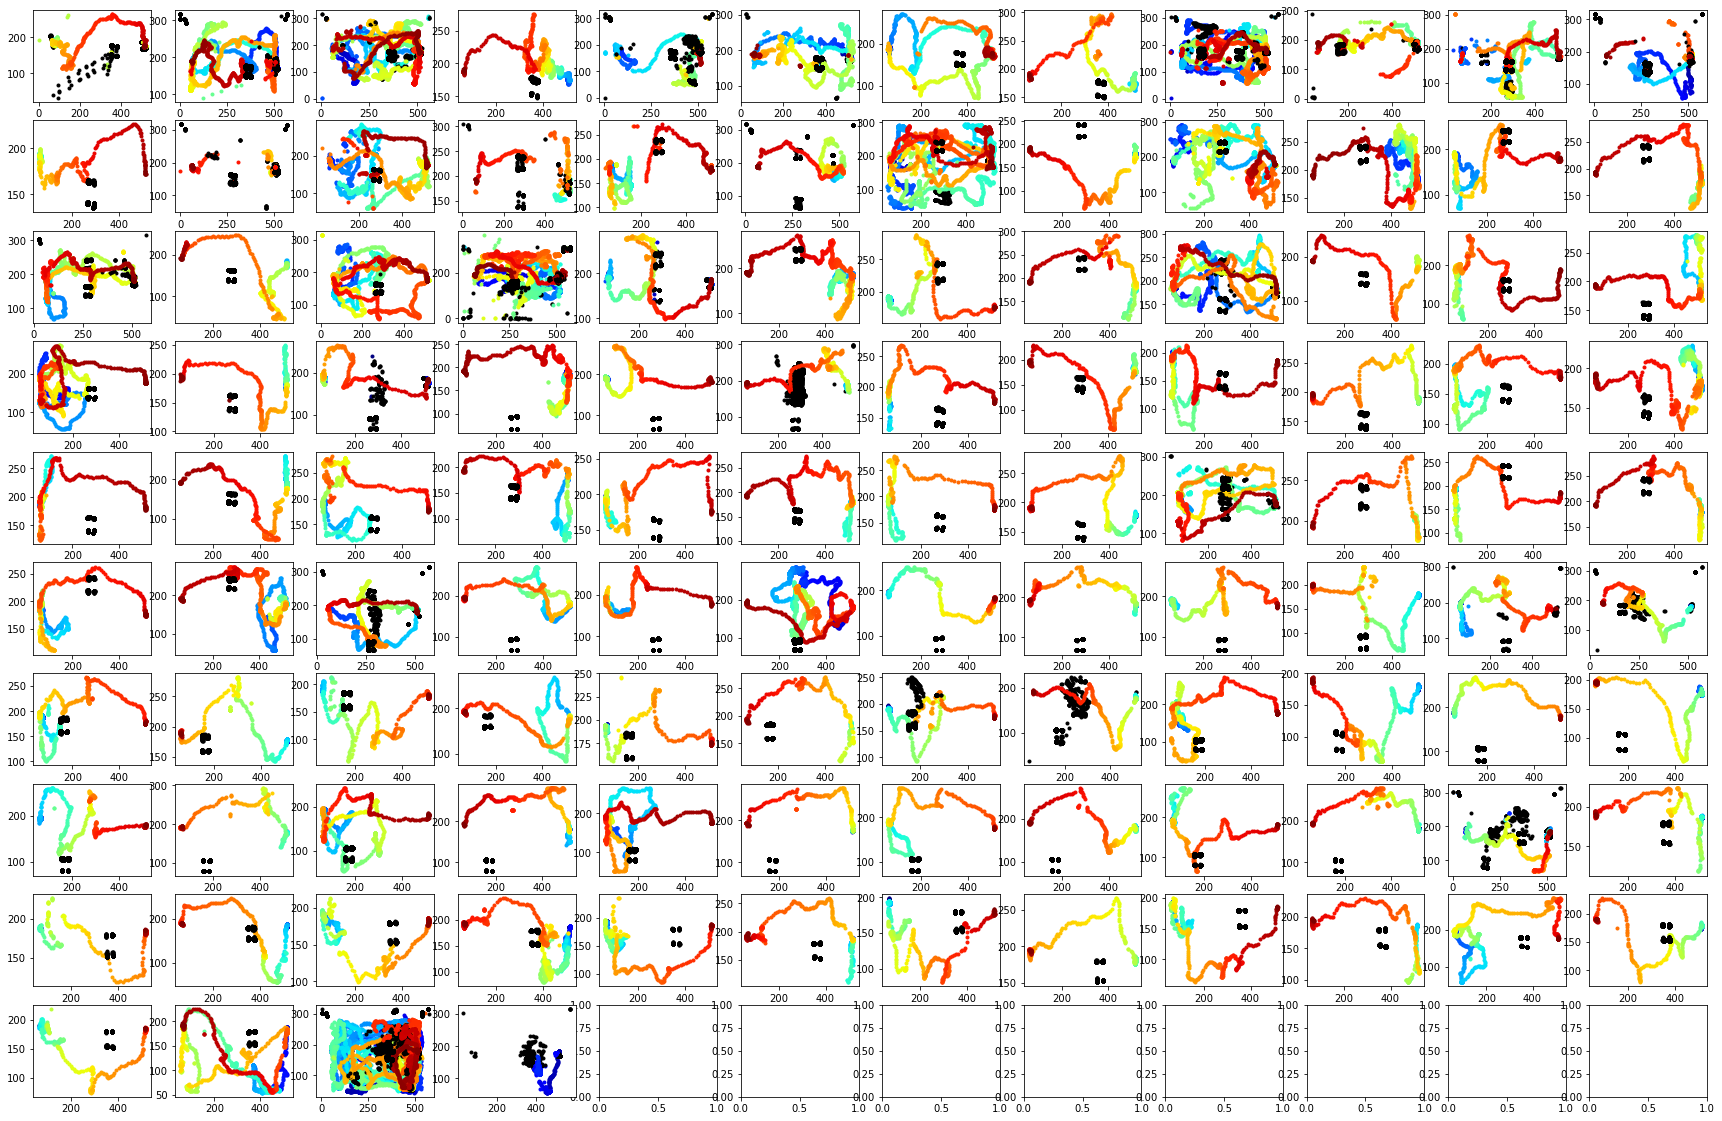

In [17]:
plt.subplots(10,int(np.ceil(len(df1)/10)), figsize=(30,20))
count = 1
for ind, row in df1.iterrows():
    plt.subplot(10,int(np.ceil(len(df1)/10)),count)
    colors = plt.cm.jet(np.linspace(0,1,len(row['trail_timestamps'])))
    for i in range(len(row['trail_timestamps'])):
        plt.plot(row['nose_x'][i],row['nose_y'][i],'.', color=colors[i])
        plt.plot(row['obstaclewTR_x'][i],row['obstaclewTR_y'][i],'.',color='k')
        plt.plot(row['obstaclewBR_x'][i],row['obstaclewBR_y'][i],'.',color='k')
        plt.plot(row['obstaclewBL_x'][i],row['obstaclewBL_y'][i],'.',color='k')
        plt.plot(row['obstaclewTL_x'][i],row['obstaclewTL_y'][i],'.',color='k')
    count += 1
plt.plot

In [16]:
colors = plt.cm.jet(np.linspace(0,1,len(row['trail_timestamps'])))
for i in range(len(row['trail_timestamps'])):
    plt.plot(row['nose_x'][i],row['nose_y'][i],'.', color=colors[i])
    plt.plot(row['obstaclewTR_x'][i],row['obstaclewTR_y'][i],'.',color='k')
    plt.plot(row['obstaclewBR_x'][i],row['obstaclewBR_y'][i],'.',color='k')
    plt.plot(row['obstaclewBL_x'][i],row['obstaclewBL_y'][i],'.',color='k')
    plt.plot(row['obstaclewTL_x'][i],row['obstaclewTL_y'][i],'.',color='k')

KeyError: 'trail_timestamps'

In [15]:
!pip install pandas --upgrade pip

  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.2
    Uninstalling pandas-1.3.2:
      Successfully uninstalled pandas-1.3.2


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\nlab\\anaconda3\\Lib\\site-packages\\~-ndas\\_libs\\algos.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

